In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sartajbhuvaji_brain_tumor_classification_mri_path = kagglehub.dataset_download('sartajbhuvaji/brain-tumor-classification-mri')

print('Data source import complete.')


Data source import complete.


In [3]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00




# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Brain Tumor Detection--- Keras/Pytorch</p>




# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Importing Modules</p>

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")



/tmp/ipython-input-4-2255241047.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch




# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Building Model Using Keras</p>



# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Preparing The Data For Keras Model</p>

In [5]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/kaggle/input/brain-tumor-classification-mri/Training/')
path_test = ('/kaggle/input/brain-tumor-classification-mri/Testing/')
img_size= 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size)))
        train_labels.append(i)

for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size)))
        test_labels.append(i)

train_img = (np.array(train_img))
test_img = (np.array(test_img))


train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

In [6]:
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)




# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Augmenting The Data</p>

In [7]:

img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

In [8]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape


((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))



# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Some Visualizations</p>

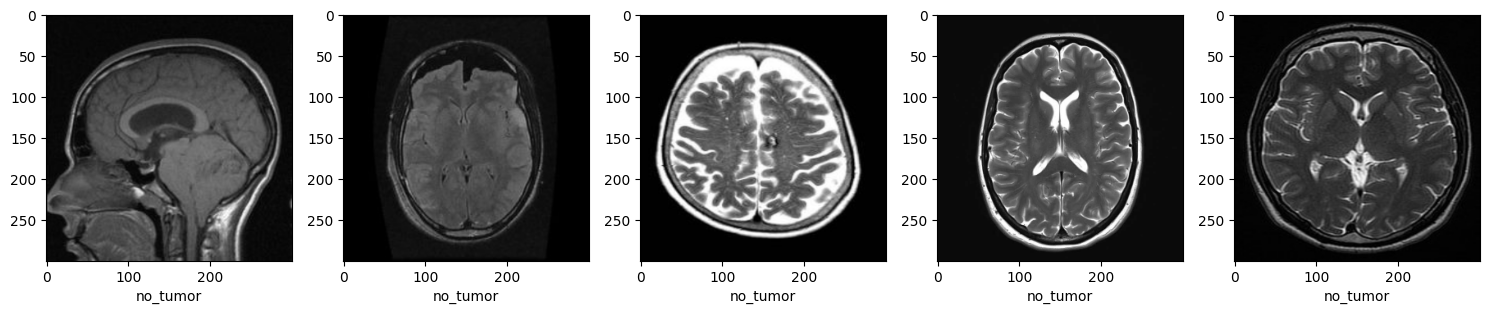

In [9]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break

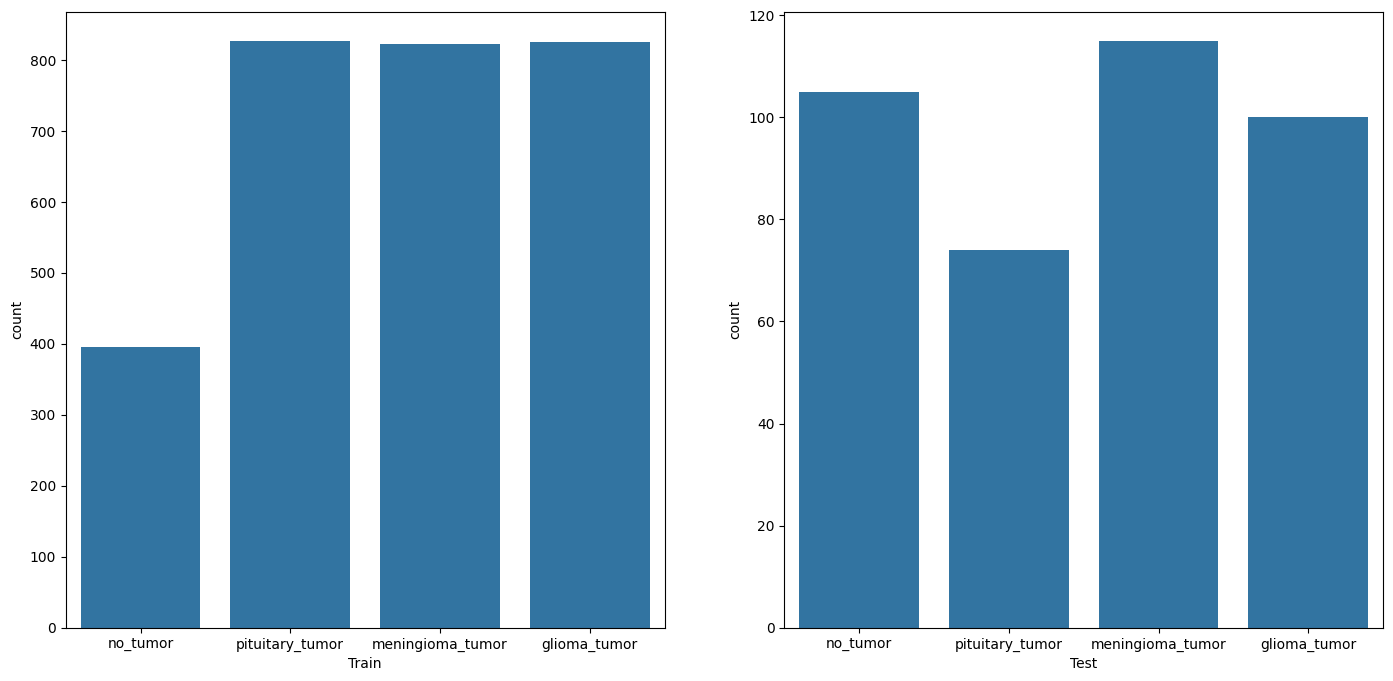

In [10]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])


In [11]:
model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(4, activation='sigmoid')
  ])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [13]:
history = model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_labels)), validation_split=0.1, epochs =4, verbose=1, batch_size=32)

Epoch 1/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.7930 - loss: 0.5245 - val_accuracy: 0.8049 - val_loss: 0.4033
Epoch 2/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.8602 - loss: 0.3654 - val_accuracy: 0.8920 - val_loss: 0.2480
Epoch 3/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.8853 - loss: 0.3152 - val_accuracy: 0.8014 - val_loss: 0.4866
Epoch 4/4
81/81 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - accuracy: 0.9041 - loss: 0.2658 - val_accuracy: 0.9443 - val_loss: 0.1453




## <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Key Notes</p>
> Adding padding here to preserve the image shape

> Adding maxpool layer to get those pixels which have the highest intensity. Reduces the image size by 2.

> Took filters of 7*7 as image size if 300 * 300 thus it would help it to learn better.

> Taken a dropout layer, to avoid overfitting.

 > The image from data generator is of type 'uint8', you need to type cast it to 'float32'.

In [14]:
model.layers[0].get_weights()[0].shape

(5, 5, 3, 32)



# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Building The Model With Pytorch</p>


# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Preparing The Data For Pytorch Model</p>

In [15]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape


((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Applying Data Transformations</p>

In [16]:
transforming_img = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
])

In [17]:

train_path = ('/kaggle/input/brain-tumor-classification-mri/Training/')
test_path = ('/kaggle/input/brain-tumor-classification-mri/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transforming_img),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transforming_img),
    batch_size=32, shuffle=True
)


#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [18]:
print(f'The classes are: {classes}')

The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [21]:


class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()


        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)

        return output

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=ConvNet(num_classes=4).to(device)


In [22]:
for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

In [23]:
images.shape

torch.Size([54, 3, 150, 150])

In [24]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()



best_accuracy=0.0

for epoch in range(20):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    # Evaluation on testing dataset
    model.eval()

    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy=test_accuracy/test_count


    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(10.0510) Train Accuracy: 0.5679442508710801 Test Accuracy: 0.37055837563451777
Epoch: 1 Train Loss: tensor(1.2999) Train Accuracy: 0.7843205574912891 Test Accuracy: 0.5076142131979695
Epoch: 2 Train Loss: tensor(0.8334) Train Accuracy: 0.8327526132404182 Test Accuracy: 0.5685279187817259
Epoch: 3 Train Loss: tensor(0.4764) Train Accuracy: 0.8905923344947735 Test Accuracy: 0.6700507614213198
Epoch: 4 Train Loss: tensor(0.3091) Train Accuracy: 0.9205574912891986 Test Accuracy: 0.6015228426395939
Epoch: 5 Train Loss: tensor(0.2084) Train Accuracy: 0.9452961672473867 Test Accuracy: 0.6421319796954315
Epoch: 6 Train Loss: tensor(0.1283) Train Accuracy: 0.9602787456445993 Test Accuracy: 0.7258883248730964
Epoch: 7 Train Loss: tensor(0.1583) Train Accuracy: 0.9554006968641114 Test Accuracy: 0.7309644670050761
Epoch: 8 Train Loss: tensor(0.0903) Train Accuracy: 0.9759581881533101 Test Accuracy: 0.7233502538071066
Epoch: 9 Train Loss: tensor(0.0447) Train Accuracy: 0



# <p style="background-color:#808080;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Conclusion </p>
<h1>In this notebook, I tried to implement a standard CNN using both Keras and pytorch.</h1>